## Data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x1, x2 = torch.meshgrid(torch.linspace(-10, 10, 100), torch.linspace(-10, 10, 100), indexing='ij')
x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)
x1.shape, x2.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [3]:
Y = x1**2 - 2*x2 + 10 + torch.randn_like(x1)
X = torch.cat([x1, x2], dim=1)
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [4]:
X[:5], Y[:5]

(tensor([[-10.0000, -10.0000],
         [-10.0000,  -9.7980],
         [-10.0000,  -9.5960],
         [-10.0000,  -9.3939],
         [-10.0000,  -9.1919]]),
 tensor([[130.8254],
         [132.1544],
         [130.1027],
         [127.6741],
         [129.2678]]))

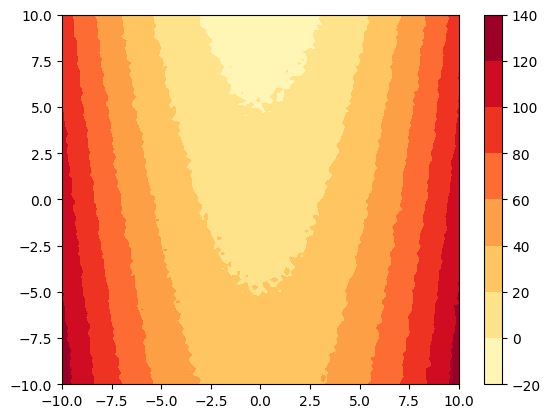

In [5]:
plt.contourf(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), Y.reshape(100, 100), cmap='YlOrRd')
plt.colorbar()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

## NN model

In [7]:
device = 'cpu'

In [8]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32)

In [9]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )
    
    def forward(self, x):
        return self.layers(x)


In [10]:
model_nn = SimpleNN().to(device)

In [11]:
from scripts.metrics import NegMeanSquaredError

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_nn.parameters())
metric = NegMeanSquaredError()

In [12]:
from scripts.train import train_model

history = train_model(
    model=model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=100,
    device=device
)

Training model for 100 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 463.081909, Train score: -463.081909, Val loss: 49.086742, Val score: -49.086742
Epoch: 2 => Train loss: 43.583836, Train score: -43.583836, Val loss: 36.627216, Val score: -36.627216
Epoch: 3 => Train loss: 33.035507, Train score: -33.035507, Val loss: 28.711191, Val score: -28.711191
Epoch: 4 => Train loss: 25.040983, Train score: -25.040983, Val loss: 21.431622, Val score: -21.431622
Epoch: 5 => Train loss: 18.892365, Train score: -18.892365, Val loss: 15.906616, Val score: -15.906616
Epoch: 6 => Train loss: 14.048924, Train score: -14.048924, Val loss: 11.959358, Val score: -11.959358
Epoch: 7 => Train loss: 9.002736, Train score: -9.002736, Val loss: 5.611490, Val score: -5.611490
Epoch: 8 => Train loss: 4.203264, Train score: -4.203264, Val loss: 3.362303, Val score: -3.362303
Epoch: 9 => Train loss: 2.679033, Train score: -2.679033, Val loss: 2.101015, Val score: -2.101015
Epoch: 10 => Train loss:

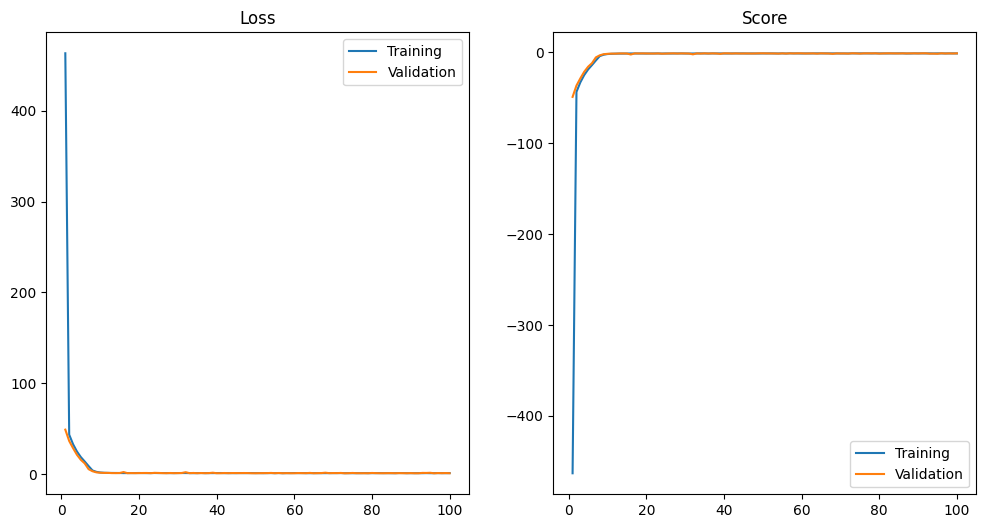

In [13]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [14]:
from scripts.test import predict

preds_train, preds_val = predict(model_nn, X_train, device), predict(model_nn, X_val, device)
score_train, score_val = metric(preds_train, Y_train), metric(preds_val, Y_val)
score_train, score_val

(tensor(-1.0830), tensor(-1.1491))

In [15]:
preds_nn = predict(model_nn, X, device).squeeze()
preds_nn.shape

torch.Size([10000])

## SVM with NTK

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
from sklearn.svm import SVR

In [23]:
from scripts.ntk import NTK

### T = 0

In [24]:
ntk_init = NTK(SimpleNN().to(device))

In [25]:
model_km_init = SVR(kernel=ntk_init.get_ntk)

In [26]:
model_km_init.fit(X_train, Y_train.squeeze())

SVR(kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7fa7416d3dc0>>)

In [27]:
preds_train, preds_val = model_km_init.predict(X_train), model_km_init.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(5.6758181696231915, 5.516856774149533)

In [28]:
preds_init = model_km_init.predict(X)
preds_init.shape

(10000,)

### T = inf

In [29]:
ntk_inf = NTK(model=model_nn)

In [30]:
model_km_inf = SVR(kernel=ntk_inf.get_ntk)

In [31]:
model_km_inf.fit(X_train, Y_train.squeeze())

SVR(kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7fa7416ace80>>)

In [32]:
preds_train, preds_val = model_km_inf.predict(X_train), model_km_inf.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(0.974920568830298, 1.134388945926919)

In [33]:
preds_inf = model_km_inf.predict(X)
preds_inf.shape

(10000,)

## Plots

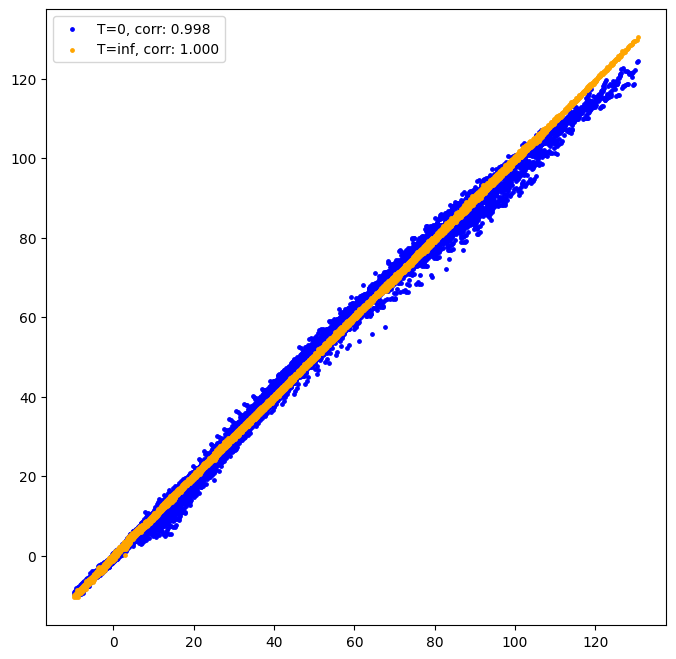

In [34]:
from scripts.utils import plot_ntk_corrs

plot_ntk_corrs(preds_nn, preds_init, preds_inf)